### Universidad Del Valle de Guatemala
### Departamento de computación
### Modelación y Simulación
### Proyecto
### Diana Lucía Fernández Villatoro - 21747
### Daniel Esteban Morales Urizar - 21785
### Brandon Rolando Sicay Cumes - 21757

In [20]:
import heapq
import random
import time

random.seed(42)
# Definimos las prioridades de triaje
PRIORIDADES = {
    "I": {"descripcion": "Prioridad absoluta, atención inmediata", "demora_maxima": 0},
    "II": {"descripcion": "Muy urgente, riesgo vital", "demora_maxima": 15},
    "III": {"descripcion": "Urgente pero estable, potencial riesgo vital", "demora_maxima": 60},
    "IV": {"descripcion": "Urgencia menor, sin riesgo vital", "demora_maxima": 120}
}
TIEMPO_MAXIMO = 100
# Clase para representar a un paciente
class Paciente:
    def __init__(self, nombre, prioridad, tiempo_llegada):
        self.nombre = nombre
        self.prioridad = prioridad
        self.tiempo_llegada = tiempo_llegada  # Se asignará al momento de llegada en la simulación

    def __lt__(self, other):
        return (self.prioridad, self.tiempo_llegada) < (other.prioridad, other.tiempo_llegada)

    def __str__(self):
        return f"{self.nombre} - Prioridad {self.prioridad}: {PRIORIDADES[self.prioridad]['descripcion']}"

# Clase para manejar eventos en la simulación
class Evento:
    def __init__(self, tiempo, tipo, paciente=None, doctor=None):
        self.tiempo = tiempo  # Momento en el que ocurre el evento
        self.tipo = tipo  # "llegada", "inicio_atencion", "fin_atencion"
        self.paciente = paciente
        self.doctor = doctor

    def __lt__(self, other):
        return self.tiempo < other.tiempo

# Generación de pacientes
def generar_pacientes(num_pacientes=10):
    nombres = ["Paciente A", "Paciente B", "Paciente C", "Paciente D", "Paciente E"]
    prioridades = ["I", "II", "III", "IV"]
    pacientes = []
    for _ in range(num_pacientes):
        nombre = random.choice(nombres)
        prioridad = random.choice(prioridades)
        tiempo_llegada = random.randint(1, TIEMPO_MAXIMO)
        pacientes.append(Paciente(nombre, prioridad, tiempo_llegada))
    return pacientes

# Pacientes compartidos por todos los modelos
pacientes_generados = generar_pacientes(10)  # Generamos 20 pacientes


Simulación de un triaje médico y atención médica dependiendo de las prioridades de los pacientes sin posibilidad de interrupción a la atención de un paciente. UN MÉDICO

In [25]:
class CentroSalud:
    def __init__(self):
        self.cola_pacientes = []
        self.eventos = []
        self.tiempo_actual = 0
        self.doctor_ocupado = False

    def agendar_evento(self, evento):
        heapq.heappush(self.eventos, evento)

    def llegada_paciente(self, paciente):
        paciente.tiempo_llegada = self.tiempo_actual  # Asignamos el tiempo de llegada
        print(f"Tiempo {self.tiempo_actual}: Llega {paciente}")
        heapq.heappush(self.cola_pacientes, paciente)
        if not self.doctor_ocupado:
            self.iniciar_atencion()

    def iniciar_atencion(self):
        if self.cola_pacientes:
            paciente = heapq.heappop(self.cola_pacientes)
            self.doctor_ocupado = True
            tiempo_atencion = random.randint(5, 20)
            fin_atencion = self.tiempo_actual + tiempo_atencion
            print(f"Tiempo {self.tiempo_actual}: Inicia atención para {paciente}, tiempo estimado {tiempo_atencion} minutos")
            self.agendar_evento(Evento(fin_atencion, "fin_atencion", paciente))

    def fin_atencion(self, paciente):
        print(f"Tiempo {self.tiempo_actual}: Finaliza atención para {paciente}")
        self.doctor_ocupado = False
        self.iniciar_atencion()

    def procesar_eventos(self, tiempo_maximo):
        while self.eventos and self.tiempo_actual <= tiempo_maximo:
            evento = heapq.heappop(self.eventos)
            self.tiempo_actual = evento.tiempo
            if evento.tipo == "llegada":
                self.llegada_paciente(evento.paciente)
            elif evento.tipo == "fin_atencion":
                self.fin_atencion(evento.paciente)

    def simular(self, tiempo_maximo):
        # Agendamos las llegadas de pacientes
        for paciente in pacientes_generados:
            self.agendar_evento(Evento(paciente.tiempo_llegada, "llegada", paciente))
        self.procesar_eventos(tiempo_maximo)


centro_salud = CentroSalud()
print("\n--- Simulación Primer Modelo ---\n")
centro_salud.simular(TIEMPO_MAXIMO)



--- Simulación Primer Modelo ---

Tiempo 1: Llega Paciente D - Prioridad III: Urgente pero estable, potencial riesgo vital
Tiempo 1: Inicia atención para Paciente D - Prioridad III: Urgente pero estable, potencial riesgo vital, tiempo estimado 10 minutos
Tiempo 4: Llega Paciente D - Prioridad I: Prioridad absoluta, atención inmediata
Tiempo 11: Finaliza atención para Paciente D - Prioridad III: Urgente pero estable, potencial riesgo vital
Tiempo 11: Inicia atención para Paciente D - Prioridad I: Prioridad absoluta, atención inmediata, tiempo estimado 19 minutos
Tiempo 29: Llega Paciente C - Prioridad II: Muy urgente, riesgo vital
Tiempo 29: Llega Paciente B - Prioridad IV: Urgencia menor, sin riesgo vital
Tiempo 30: Llega Paciente A - Prioridad II: Muy urgente, riesgo vital
Tiempo 30: Finaliza atención para Paciente D - Prioridad I: Prioridad absoluta, atención inmediata
Tiempo 30: Inicia atención para Paciente C - Prioridad II: Muy urgente, riesgo vital, tiempo estimado 17 minutos
Ti

Simulación de un triaje médico y atención médica dependiendo de las prioridades de los pacientes con posibilidad de interrupción a la atención de un paciente. UN MÉDICO

In [ ]:
class CentroSaludInterrumpible(CentroSalud):
    def __init__(self):
        super().__init__()
        self.paciente_actual = None

    def llegada_paciente(self, paciente):
        paciente.tiempo_llegada = self.tiempo_actual  # Asignamos el tiempo de llegada
        print(f"Tiempo {self.tiempo_actual}: Llega {paciente}")
        if not self.doctor_ocupado:
            self.iniciar_atencion(paciente)
        else:
            # Verificamos si el nuevo paciente tiene mayor prioridad
            if paciente.prioridad < self.paciente_actual.prioridad:
                print(f"Tiempo {self.tiempo_actual}: {paciente} interrumpe la atención de {self.paciente_actual}")
                # Regresamos al paciente actual a la cola
                heapq.heappush(self.cola_pacientes, self.paciente_actual)
                # Atendemos al nuevo paciente
                self.iniciar_atencion(paciente)
            else:
                # Agregamos el nuevo paciente a la cola
                heapq.heappush(self.cola_pacientes, paciente)

    def iniciar_atencion(self, paciente=None):
        if not paciente and self.cola_pacientes:
            paciente = heapq.heappop(self.cola_pacientes)
        if paciente:
            self.paciente_actual = paciente
            self.doctor_ocupado = True
            tiempo_atencion = random.randint(5, 20)
            fin_atencion = self.tiempo_actual + tiempo_atencion
            print(f"Tiempo {self.tiempo_actual}: Inicia atención para {paciente}, tiempo estimado {tiempo_atencion} minutos")
            self.agendar_evento(Evento(fin_atencion, "fin_atencion", paciente))

    def fin_atencion(self, paciente):
        print(f"Tiempo {self.tiempo_actual}: Finaliza atención para {paciente}")
        self.doctor_ocupado = False
        self.paciente_actual = None
        self.iniciar_atencion()

# Ejecutar la simulación del segundo modelo
centro_salud_interrumpible = CentroSaludInterrumpible()
print("\n--- Simulación Segundo Modelo ---\n")
centro_salud_interrumpible.simular(TIEMPO_MAXIMO)



--- Simulación Segundo Modelo ---

Tiempo 2: Llega Paciente D - Prioridad IV: Urgencia menor, sin riesgo vital
Tiempo 2: Inicia atención para Paciente D - Prioridad IV: Urgencia menor, sin riesgo vital, tiempo estimado 7 minutos
Tiempo 9: Finaliza atención para Paciente D - Prioridad IV: Urgencia menor, sin riesgo vital
Tiempo 13: Llega Paciente D - Prioridad III: Urgente pero estable, potencial riesgo vital
Tiempo 13: Inicia atención para Paciente D - Prioridad III: Urgente pero estable, potencial riesgo vital, tiempo estimado 8 minutos
Tiempo 21: Finaliza atención para Paciente D - Prioridad III: Urgente pero estable, potencial riesgo vital
Tiempo 26: Llega Paciente E - Prioridad III: Urgente pero estable, potencial riesgo vital
Tiempo 26: Inicia atención para Paciente E - Prioridad III: Urgente pero estable, potencial riesgo vital, tiempo estimado 6 minutos
Tiempo 26: Llega Paciente C - Prioridad III: Urgente pero estable, potencial riesgo vital
Tiempo 27: Llega Paciente D - Priori

Simulación de un centro médico con VARIOS DOCTORES, con posibilidad de que una emergencia interrumpa la atención de un paciente de menor prioridad

In [ ]:
import matplotlib.pyplot as plt

# Estadísticas de atención
tiempos_espera = []
tiempos_atencion_por_prioridad = { "I": [], "II": [], "III": [], "IV": [] }
pacientes_en_espera_tiempo = []
doctores_atenciones = {}

class Doctor:
    def __init__(self, id_doctor):
        self.id_doctor = id_doctor
        self.ocupado = False
        self.paciente_actual = None
        self.tiempo_fin_atencion = 0

    def __str__(self):
        return f"Doctor {self.id_doctor}"

class CentroSaludMulticanal:
    def __init__(self, num_doctores, politica_interrupcion=True):
        self.cola_pacientes = []
        self.eventos = []
        self.tiempo_actual = 0
        self.politica_interrupcion = politica_interrupcion
        self.doctores = [Doctor(i) for i in range(num_doctores)]
        for doctor in self.doctores:
            doctores_atenciones[doctor.id_doctor] = 0  # Inicializar conteo de atenciones por doctor

    def agendar_evento(self, evento):
        heapq.heappush(self.eventos, evento)

    def llegada_paciente(self, paciente):
        paciente.tiempo_llegada = self.tiempo_actual  # Asignamos el tiempo de llegada
        print(f"Tiempo {self.tiempo_actual}: Llega {paciente}")
        
        # Buscar un doctor disponible
        doctor_libre = next((doctor for doctor in self.doctores if not doctor.ocupado), None)

        if doctor_libre:
            # Si hay un doctor libre, iniciamos atención inmediata
            self.iniciar_atencion(paciente, doctor_libre)
        else:
            # Si todos los doctores están ocupados, el paciente espera en la cola
            heapq.heappush(self.cola_pacientes, paciente)
        
        # Guardar el número de pacientes en espera en el tiempo actual
        pacientes_en_espera_tiempo.append((self.tiempo_actual, len(self.cola_pacientes)))

    def iniciar_atencion(self, paciente, doctor):
        doctor.ocupado = True
        doctor.paciente_actual = paciente
        tiempo_atencion = random.randint(5, 20)  # Simula tiempo de atención
        doctor.tiempo_fin_atencion = self.tiempo_actual + tiempo_atencion

        # Calcular y guardar el tiempo de espera del paciente
        tiempo_espera = self.tiempo_actual - paciente.tiempo_llegada
        tiempos_espera.append(tiempo_espera)
        
        # Guardar el tiempo de atención por prioridad
        tiempos_atencion_por_prioridad[paciente.prioridad].append(tiempo_atencion)
        
        # Contar la atención realizada por el doctor
        doctores_atenciones[doctor.id_doctor] += 1

        print(f"Tiempo {self.tiempo_actual}: {doctor} inicia atención para {paciente}, tiempo estimado {tiempo_atencion} minutos")
        self.agendar_evento(Evento(doctor.tiempo_fin_atencion, "fin_atencion", paciente, doctor))

    def fin_atencion(self, doctor):
        paciente = doctor.paciente_actual
        print(f"Tiempo {self.tiempo_actual}: {doctor} finaliza atención para {paciente}")
        doctor.ocupado = False
        doctor.paciente_actual = None
        # Si hay más pacientes en la cola, atender al siguiente
        if self.cola_pacientes:
            siguiente_paciente = heapq.heappop(self.cola_pacientes)
            self.iniciar_atencion(siguiente_paciente, doctor)

    def procesar_eventos(self, tiempo_maximo):
        while self.eventos and self.tiempo_actual <= tiempo_maximo:
            evento = heapq.heappop(self.eventos)
            self.tiempo_actual = evento.tiempo
            if evento.tipo == "llegada":
                self.llegada_paciente(evento.paciente)
            elif evento.tipo == "fin_atencion":
                self.fin_atencion(evento.doctor)

    def simular(self, tiempo_maximo):
        # Agendamos las llegadas de pacientes
        for paciente in pacientes_generados:
            self.agendar_evento(Evento(paciente.tiempo_llegada, "llegada", paciente))
        self.procesar_eventos(tiempo_maximo)

# Ejecutar la simulación del tercer modelo
num_doctores = 3
centro_salud_multicanal = CentroSaludMulticanal(num_doctores)
print("\n--- Simulación Tercer Modelo ---\n")
centro_salud_multicanal.simular(TIEMPO_MAXIMO)




--- Simulación Tercer Modelo ---

Tiempo 17: Llega Paciente D - Prioridad IV: Urgencia menor, sin riesgo vital
Tiempo 17: Doctor 0 inicia atención para Paciente D - Prioridad IV: Urgencia menor, sin riesgo vital, tiempo estimado 20 minutos
Tiempo 24: Llega Paciente C - Prioridad III: Urgente pero estable, potencial riesgo vital
Tiempo 24: Doctor 1 inicia atención para Paciente C - Prioridad III: Urgente pero estable, potencial riesgo vital, tiempo estimado 6 minutos
Tiempo 30: Doctor 1 finaliza atención para Paciente C - Prioridad III: Urgente pero estable, potencial riesgo vital
Tiempo 32: Llega Paciente E - Prioridad II: Muy urgente, riesgo vital
Tiempo 32: Doctor 1 inicia atención para Paciente E - Prioridad II: Muy urgente, riesgo vital, tiempo estimado 8 minutos
Tiempo 37: Doctor 0 finaliza atención para Paciente D - Prioridad IV: Urgencia menor, sin riesgo vital
Tiempo 40: Doctor 1 finaliza atención para Paciente E - Prioridad II: Muy urgente, riesgo vital
Tiempo 52: Llega Pacie

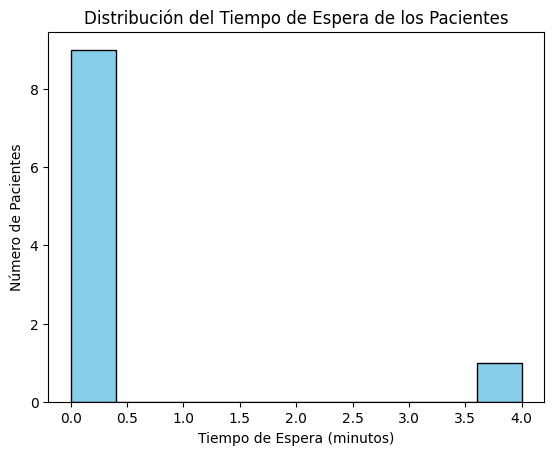

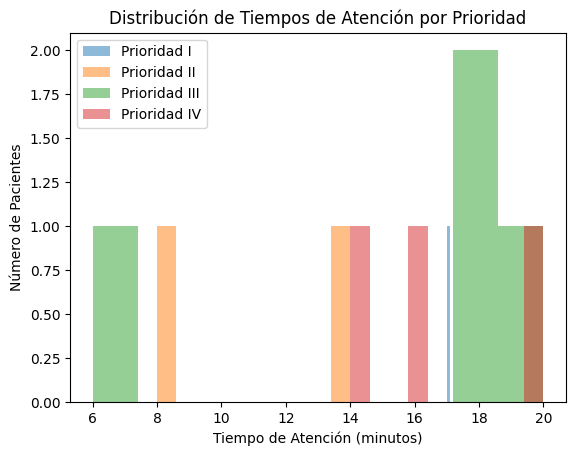

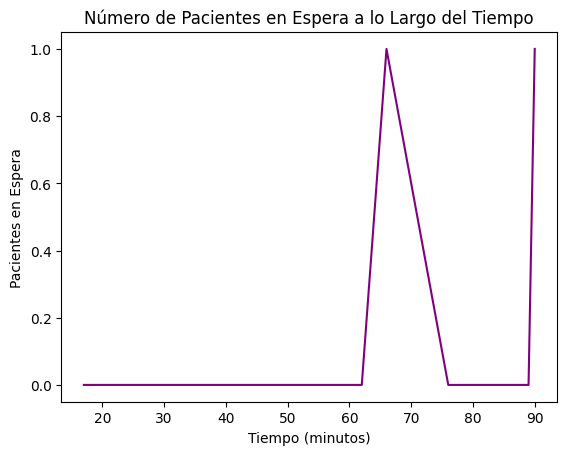

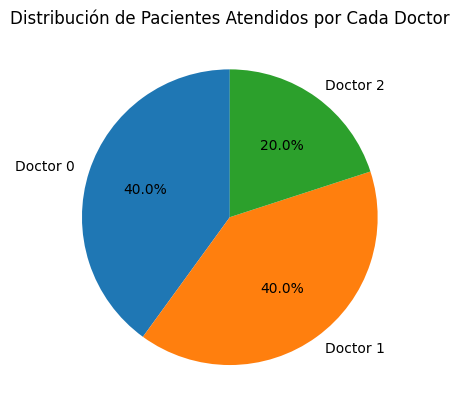

In [14]:
import matplotlib.pyplot as plt

# 1. Tiempo de espera promedio de los pacientes
plt.figure()
plt.hist(tiempos_espera, bins=10, color='skyblue', edgecolor='black')
plt.title("Distribución del Tiempo de Espera de los Pacientes")
plt.xlabel("Tiempo de Espera (minutos)")
plt.ylabel("Número de Pacientes")
plt.show()

# 2. Distribución de tiempos de atención por prioridad
plt.figure()
for prioridad, tiempos in tiempos_atencion_por_prioridad.items():
    plt.hist(tiempos, bins=10, alpha=0.5, label=f'Prioridad {prioridad}')
plt.title("Distribución de Tiempos de Atención por Prioridad")
plt.xlabel("Tiempo de Atención (minutos)")
plt.ylabel("Número de Pacientes")
plt.legend()
plt.show()

# 3. Número de pacientes en espera a lo largo del tiempo
tiempos, pacientes_en_espera = zip(*pacientes_en_espera_tiempo)
plt.figure()
plt.plot(tiempos, pacientes_en_espera, color='purple')
plt.title("Número de Pacientes en Espera a lo Largo del Tiempo")
plt.xlabel("Tiempo (minutos)")
plt.ylabel("Pacientes en Espera")
plt.show()

# 4. Cantidad de pacientes atendidos por cada doctor
doctor_ids, atenciones = zip(*doctores_atenciones.items())
plt.figure()
plt.pie(atenciones, labels=[f'Doctor {id}' for id in doctor_ids], autopct='%1.1f%%', startangle=90)
plt.title("Distribución de Pacientes Atendidos por Cada Doctor")
plt.show()
